In [1]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import functions notebook and load data set here
import sys
sys.path.append("../")
from time_series_functions import *

In [3]:
df=pd.read_csv('../zillow_data.csv')

In [4]:
df=melt_data2(df)

In [5]:
df.set_index('time',inplace=True)

In [6]:
# Rename RegionName to be Zipcode
df=df.rename({'RegionName':'Zipcode'},axis='columns')

In [7]:
#drop no longer relevant columns
df.drop(['RegionID','SizeRank','City','CountyName'],axis=1,inplace=True)

In [8]:
Arizona_df= df[(df['State'] == 'AZ')]

In [9]:
Arizona_df

,Zipcode,State,Metro,value
time,,,,
1996-04-01,85032,AZ,Phoenix,95400.0
1996-04-01,85710,AZ,Tucson,94600.0
1996-04-01,85225,AZ,Phoenix,101200.0
1996-04-01,85308,AZ,Phoenix,124800.0
1996-04-01,85281,AZ,Phoenix,81200.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [10]:
Arizona_recent_yrs=Arizona_df['2009-01-01':'2018-04-01']

In [11]:
Arizona_recent_yrs

,Zipcode,State,Metro,value
time,,,,
2009-01-01,85032,AZ,Phoenix,190200.0
2009-01-01,85710,AZ,Tucson,171100.0
2009-01-01,85225,AZ,Phoenix,179900.0
2009-01-01,85308,AZ,Phoenix,212000.0
2009-01-01,85281,AZ,Phoenix,181300.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [12]:
Phoenix_data = Arizona_recent_yrs[(Arizona_recent_yrs['Metro'] == 'Phoenix')]

In [13]:
Phoenix_data
Phoenix_data=Phoenix_data.drop(['State','Metro'],axis=1)

In [14]:
top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
(Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                             (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]

In [15]:
def get_zip(zipcode):
    top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
    (Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                            (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]
    zip_zipcode=top_10_zips_phx[top_10_zips_phx['Zipcode']==zipcode]
    #zip_zipcode.drop(['index'],axis=1,inplace=True)
    zip_zipcode.reset_index(inplace=True)
    
    # shift by one period (month)
    resampled_shift_1 = zip_zipcode[['value']].shift(1)
    resampled_shift_1.bfill(inplace=True)

#reset the indexes to perform calculation of growth
    top_10_zips_phx = zip_zipcode.reset_index()
    resampled_shift_1 = resampled_shift_1.reset_index()

#Growth Calculation
    zip_zipcode['growth'] = (zip_zipcode['value'] - resampled_shift_1['value'])/(resampled_shift_1['value'])
    zip_zipcode['growth']= abs(zip_zipcode['growth'])
#set the index back to zipcode and time multi-index
    zip_zipcode.set_index(['time'],inplace=True)
    
    zip_zipcode.drop('Zipcode',axis=1,inplace=True)
    data= top_10_zips_phx
    print(f'The stationarity check for zipcode {zipcode} before adjustments:{stationarity_check(zip_zipcode.growth)}')
    
    #Original Plot
    fig, ax = plt.subplots()
    ax.plot(zip_zipcode.growth)
    ax.set_title(f"Original Zipcode Plot for {zipcode}");
    
    #log values and dropna
    log_zipcode= abs(np.log(zip_zipcode.growth))
    log_zipcode.dropna(inplace=True)
    
    # get roll mean and subtract
    roll_mean = log_zipcode.rolling(window=7,center=False).mean()
    data_minus_roll_mean = log_zipcode-roll_mean
    
    #Drop missing values
    data_minus_roll_mean.dropna(inplace=True)
    return data_minus_roll_mean
    #Plot the data minus roll mean
    #data_minus_roll_mean.plot(figsize=(10,6));
    fig, ax = plt.subplots()
    ax.plot(data_minus_roll_mean)
    ax.set_title(f"Final Zipcode Plot for {zipcode}");

    print(f'The stationarity check for zipcode {zipcode}, after adjustments:{stationarity_check(data_minus_roll_mean)}')
    


Results of Dickey-Fuller Test: 

Test Statistic                  -4.024064
p-value                          0.001290
#Lags Used                       2.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64
The stationarity check for zipcode 85263 before adjustments:None


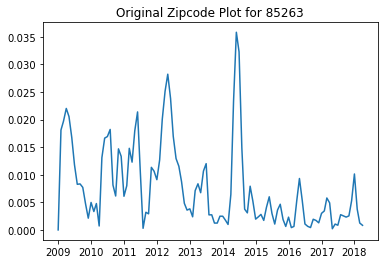

In [16]:
minus_roll_mean=get_zip(85263)

In [17]:
print(minus_roll_mean)

time
2009-08-01    0.657513
2009-09-01    0.538418
2009-10-01    0.482997
2009-11-01    0.755636
2009-12-01    1.225511
                ...   
2017-12-01   -0.913729
2018-01-01   -1.238193
2018-02-01   -0.034541
2018-03-01    0.954578
2018-04-01    1.201768
Name: growth, Length: 105, dtype: float64


In [18]:
# find the index which allows us to split off 20% of the data
cutoff = round(minus_roll_mean.shape[0]*0.8)
cutoff

84

In [19]:
# Define train and test sets according to the index found above
train = minus_roll_mean[:cutoff]

test = minus_roll_mean[cutoff:]

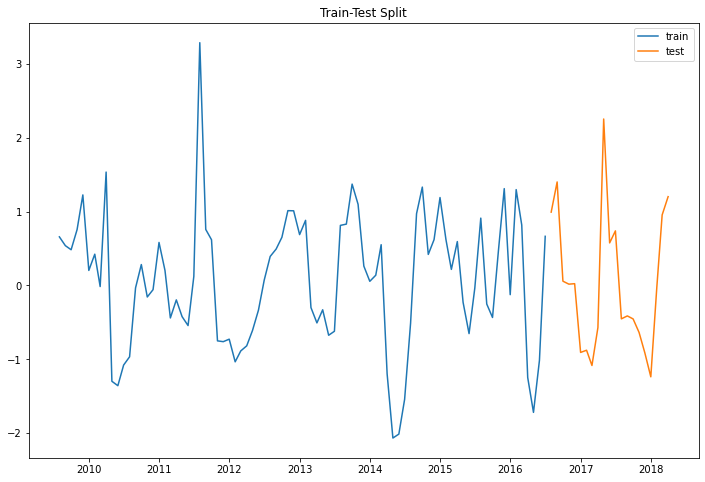

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [21]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] [28 29 30 31 32 33 34 35 36 37 38 39 40 41]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41] [42 43 44 45 46 47 48 49 50 51 52 53 54 55]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55] [56 57 58 59 60 61 62 63 64 65 66 67 68 69]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69] [70 71 72 73 74 75 76 77 78 79 80 81 82 83]


In [22]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
baseline = train.shift(1)
baseline

time
2009-08-01         NaN
2009-09-01    0.657513
2009-10-01    0.538418
2009-11-01    0.482997
2009-12-01    0.755636
                ...   
2016-03-01    1.297324
2016-04-01    0.817343
2016-05-01   -1.248252
2016-06-01   -1.719616
2016-07-01   -1.015507
Name: growth, Length: 84, dtype: float64

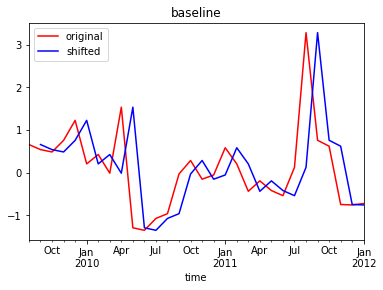

In [23]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
baseline[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('baseline')
ax.legend();

In [24]:
np.sqrt(mean_squared_error(train[1:], baseline.dropna()))

0.8872093403487131

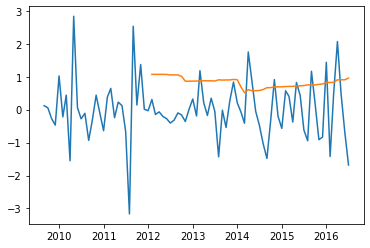

In [25]:
fig, ax = plt.subplots()
residuals = baseline[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

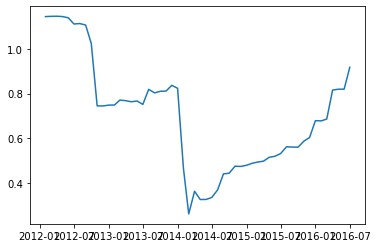

In [26]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

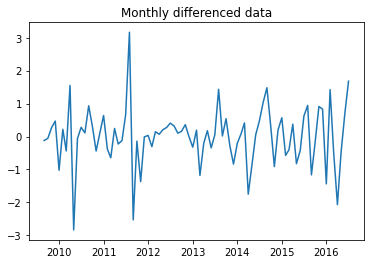

In [27]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Monthly differenced data');

In [28]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 5.727173303196344e-08,
 so we can safely assume that the differenced data is stationary.


In [29]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

2009-08-01    0.000000
2009-09-01    0.657512
2009-10-01    0.554712
2009-11-01    0.490579
2009-12-01    0.718333
                ...   
2016-03-01    1.102647
2016-04-01    0.883015
2016-05-01   -0.965631
2016-06-01   -1.655123
2016-07-01   -1.111845
Freq: MS, Name: predicted_mean, Length: 84, dtype: float64

In [30]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   84
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -107.079
Date:                Wed, 05 Jan 2022   AIC                            218.159
Time:                        11:31:21   BIC                            222.996
Sample:                    08-01-2009   HQIC                           220.102
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1368      0.082     -1.659      0.097      -0.298       0.025
sigma2         0.7727      0.084      9.173      0.000       0.608       0.938
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                16.62
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.09
Prob(H) (two-sided):                  0.75   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   84
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -107.839
Date:                Wed, 05 Jan 2022   AIC                            217.678
Time:                        11:31:21   BIC                            220.097
Sample:                    08-01-2009   HQIC                           218.650
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.7871      0.082      9.620      0.000       0.627       0.947
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):                21.44
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.19
Prob(H) (two-sided):                  0.55   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 217.67786021157207
AR(1, 1, 0) AIC: 218.15872604462965


In [33]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.8767210514371164

In [34]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

0.8848256292173108

In [35]:
train.index

DatetimeIndex(['2009-08-01', '2009-09-01', '2009-10-01', '2009-11-01',
               '2009-12-01', '2010-01-01', '2010-02-01', '2010-03-01',
               '2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01',
               '2010-08-01', '2010-09-01', '2010-10-01', '2010-11-01',
               '2010-12-01', '2011-01-01', '2011-02-01', '2011-03-01',
               '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
               '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01',
               '2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01',
               '2012-04-01', '2012-05-01', '2012-06-01', '2012-07-01',
               '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01',
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
      

In [36]:
train_with_ind = train.reset_index()

In [37]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.1029003094698908
0.8095441296575199
0.8281689167806616
1.2651351086819898
0.9263726526243923


In [38]:
ar_1.arparams

array([-0.136823])

In [39]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1, 1), train[1:].diff().dropna())
print(lr.coef_)

[-0.13855438]


In [40]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

2009-08-01    0.000000
2009-09-01    0.657512
2009-10-01    0.555075
2009-11-01    0.510807
2009-12-01    0.720238
                ...   
2016-03-01    1.293965
2016-04-01    0.670086
2016-05-01   -0.837760
2016-06-01   -1.316615
2016-07-01   -1.055019
Freq: MS, Name: predicted_mean, Length: 84, dtype: float64

In [41]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

217.67786021157207
218.15872604462965
218.1271583558828


In [42]:
y_hat_ar1 = ar_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.865865197718804

In [43]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.1458746046273014
0.7701146437159333
0.8386472229811318
1.257359955034469
0.9234178652442836


### Moving Avg

In [44]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

2009-08-01    0.072101
2009-09-01    0.295932
2009-10-01    0.180690
2009-11-01    0.211567
2009-12-01    0.324678
                ...   
2016-03-01    0.786168
2016-04-01    0.086599
2016-05-01   -0.548649
2016-06-01   -0.472438
2016-07-01   -0.180444
Freq: MS, Name: predicted_mean, Length: 84, dtype: float64

In [45]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   84
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -99.075
Date:                Wed, 05 Jan 2022   AIC                            204.151
Time:                        11:31:23   BIC                            211.443
Sample:                    08-01-2009   HQIC                           207.082
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0721      0.129      0.558      0.577      -0.181       0.325
ma.L1          0.4650      0.085      5.490      0.000       0.299       0.631
sigma2         0.6176      0.070      8.816      0.000       0.480       0.755
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):                16.33
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.44
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
ma_1 = ARIMA(train, order=(0, 1, 1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

217.67786021157207
218.15872604462965
218.1271583558828
217.33625944639655


In [47]:
y_hat_ar1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.8722598599009185

In [48]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.2147040213579419
0.8249576228539285
0.843729944053478
1.2484769922554935
0.9222904189775513


In [49]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

2009-08-01    0.000000
2009-09-01    0.657512
2009-10-01    0.560752
2009-11-01    0.540045
2009-12-01    0.712193
                ...   
2016-03-01    0.822097
2016-04-01    0.109888
2016-05-01   -0.541901
2016-06-01   -0.479289
2016-07-01   -0.191342
Freq: MS, Name: predicted_mean, Length: 84, dtype: float64

In [50]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

217.67786021157207
218.15872604462965
218.1271583558828
217.33625944639655
206.46050116098513


In [51]:
y_hat_ar1 = ma_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.8055923762581507

In [52]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.2105092589974649
0.7375548683749813
0.7503453205610668
1.1660167787855176
0.9141585698934046


### ARMA

In [53]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

In [54]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

217.67786021157207
218.15872604462965
218.1271583558828
217.33625944639655
206.46050116098513
205.8447968450763


In [55]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [56]:
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

0.8848256292173108
0.8767210514371164
0.865865197718804
0.8722598599009185
0.8055923762581507
0.7846903315214993


In [57]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.1479894684049174
0.7521366193098535
0.6683453487516905
1.214504507113668
0.9169797859095434


In [58]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [59]:
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_21))

1.1161562776167728
1.015395157928597
0.9311505431712485
0.9492281731905793
0.9040652837926882
0.9039546981200546


In [60]:
sari_mod =SARIMAX(train,
                  order=(0, 1, 0),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [61]:
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      order=(1, 1, 1),
                     seasonal_order=(0, 1, 1, 52),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.9918207109262119
1.0028487445435028
0.8657264194340393
1.766465120392176
1.2082736342738012


In [62]:
sari_mod = SARIMAX(minus_roll_mean,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [63]:
forecast = sari_mod.forecast(steps=52)

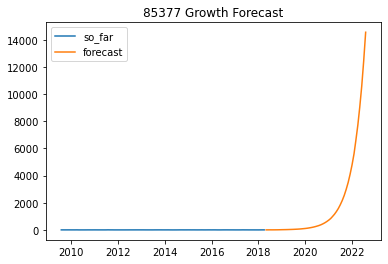

In [64]:
fig, ax = plt.subplots()
ax.plot(minus_roll_mean, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('85377 Growth Forecast')

plt.legend();